In [1]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [2]:
import tangramlit as tgl

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [3]:
import scanpy as sc
import numpy as np 
import torch
import yaml

In [4]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data"

# Training config

In [5]:
# Read config yaml
with open("train_config.yaml", "r") as f:
        config = yaml.safe_load(f)

config  # contains rng seed!

{'cluster_label': 'Allen.class_label',
 'lambda_count': 1e-05,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 1,
 'learning_rate': 0.1,
 'filter': False,
 'num_epochs': 1000,
 'random_state': 42,
 'target_count': None}

# Dataset 0

## Data loading

In [6]:
adata_sc = sc.read_h5ad(data_path + "/counts100k_norm_wo_raw_light.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 100000 × 31053
    obs: 'nUMI', 'nGene', 'dataset', 'QC', 'cluster', 'Allen.cluster_id', 'Allen.cluster_label', 'Allen.cluster_color', 'Allen.class_label', 'Allen.subclass_label', 'comb.QC'
    var: 'gene_ids', 'feature_types'

In [7]:
adata_st = sc.read_h5ad(data_path + "/slice200_norm_with_spatial.h5ad")
adata_st

AnnData object with n_obs × n_vars = 2155 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'instance_id', 'centroid_x', 'centroid_y', 'region'
    var: 'is_sequential', 'is_combinatorial'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

## Train/Val genes split

In [8]:
# Get shared genes (case-insensitive)
sc_genes = {gene.lower(): gene for gene in adata_sc.var_names}
st_genes = {gene.lower(): gene for gene in adata_st.var_names}

# Find intersection of lowercase gene names
shared_genes_set = set(sc_genes.keys()) & set(st_genes.keys())
shared_genes = [gene_lower for gene_lower in shared_genes_set]

# Shuffle the shared genes
shared_genes = np.array(shared_genes)
np.random.shuffle(shared_genes)

# Split into train and validation
train_ratio = 0.8
n_train = int(len(shared_genes) * train_ratio)
train_genes = shared_genes[:n_train]
val_genes = shared_genes[n_train:]

print(len(train_genes), "training genes: ", train_genes[0:10], "...")
print(len(val_genes), "validation genes: ", val_genes[0:10], "...")

202 training genes:  ['cdh20' 'rnf152' 'cacng5' 'cdcp1' 'rgs6' 'unc13c' 'zfp804b' 'cxcl14'
 'brinp3' 'hpse'] ...
51 validation genes:  ['asic4' 'osr1' 'il1rapl2' 'cdh12' 'syt10' 'ano4' 'ccdc162' 'ptprk'
 'c1qtnf7' 'egln3'] ...


## Full Mapper (no Filter)

### Model training

In [10]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 172 M  | n/a  
---------------------------------------------------------
172 M     Trainable params
0         Non-trainable params
172 M     Total params
689.377   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([80799, 51])
G matrix shape: torch.Size([2133, 51])

Validation 0: {'val_score': 0.37933582067489624, 'val_sparsity-weighted_score': 0.00921754352748394, 'val_AUC': 0.48967745900154114, 'val_entropy': 0.9348850846290588}


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 201 genes
S matrix shape: torch.Size([80799, 201])
G matrix shape: torch.Size([2133, 201])


Trainig:   0%|          | 1/1000 [00:24<6:56:10, 25.00s/it]

Epoch 0: {'loss': -3.2371301651000977, 'main_loss': 0.34696489572525024, 'vg_reg': 0.3545142710208893, 'kl_reg': 1.1205906425004741e-08, 'entropy_reg': -0.0005790185532532632, 'l1_term': 1.375221785337999e-07, 'l2_term': 1.7236176375057255e-10, 'sparsity_term': 0.4380369186401367, 'neighborhood_term': 0.5080392360687256, 'getis_ord_term': 0.5979135036468506, 'moran_term': -0.0007117430213838816, 'geary_term': 0.9929519891738892, 'ct_island_term': 0.0}


Trainig:   5%|▍         | 49/1000 [19:49<6:25:21, 24.31s/it]Metric val_score improved. New best score: 0.512
Epoch 49, global step 50: 'val_score' reached 0.51232 (best 0.51232), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=49-val_score=0.512.ckpt' as top 3



Validation 49: {'val_score': 0.5123218894004822, 'val_sparsity-weighted_score': 0.011811631731688976, 'val_AUC': 0.5904642343521118, 'val_entropy': 0.7718020081520081}


Trainig:  10%|▉         | 99/1000 [40:10<6:03:07, 24.18s/it]Metric val_score improved by 0.064 >= min_delta = 0.001. New best score: 0.576
Epoch 99, global step 100: 'val_score' reached 0.57593 (best 0.57593), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=99-val_score=0.576.ckpt' as top 3



Validation 99: {'val_score': 0.5759328007698059, 'val_sparsity-weighted_score': 0.01319875754415989, 'val_AUC': 0.6689729690551758, 'val_entropy': 0.2503460943698883}


Trainig:  10%|█         | 101/1000 [41:05<6:25:29, 25.73s/it]

Epoch 100: {'loss': -5.651510715484619, 'main_loss': 0.8037725687026978, 'vg_reg': 0.5780181884765625, 'kl_reg': 8.62504166434519e-05, 'entropy_reg': -0.00015505118062719703, 'l1_term': 1.6208795727834513e-07, 'l2_term': 2.6414820331055466e-10, 'sparsity_term': 0.8229242563247681, 'neighborhood_term': 0.8392689228057861, 'getis_ord_term': 0.865180253982544, 'moran_term': 0.7444354295730591, 'geary_term': 0.9987134337425232, 'ct_island_term': 0.000560640066396445, 'lr': 0.10000000149011612, 'val_score': 0.5759328007698059, 'val_sparsity-weighted_score': 0.01319875754415989, 'val_AUC': 0.6689729690551758, 'val_entropy': 0.2503460943698883}


Trainig:  15%|█▍        | 149/1000 [1:00:41<5:49:35, 24.65s/it]Metric val_score improved by 0.005 >= min_delta = 0.001. New best score: 0.581
Epoch 149, global step 150: 'val_score' reached 0.58108 (best 0.58108), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=149-val_score=0.581.ckpt' as top 3



Validation 149: {'val_score': 0.5810781717300415, 'val_sparsity-weighted_score': 0.013292583636939526, 'val_AUC': 0.6768714189529419, 'val_entropy': 0.12664811313152313}


Trainig:  20%|█▉        | 199/1000 [1:21:13<5:26:48, 24.48s/it]Metric val_score improved by 0.002 >= min_delta = 0.001. New best score: 0.583
Epoch 199, global step 200: 'val_score' reached 0.58289 (best 0.58289), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=199-val_score=0.583.ckpt' as top 3



Validation 199: {'val_score': 0.5828892588615417, 'val_sparsity-weighted_score': 0.013332081958651543, 'val_AUC': 0.6790654063224792, 'val_entropy': 0.09777195006608963}


Trainig:  20%|██        | 201/1000 [1:22:08<5:43:26, 25.79s/it]

Epoch 200: {'loss': -5.789432525634766, 'main_loss': 0.8292161822319031, 'vg_reg': 0.6090607047080994, 'kl_reg': 0.00011237178841838613, 'entropy_reg': -6.05547938903328e-05, 'l1_term': 1.6351728504560015e-07, 'l2_term': 2.7332541785440867e-10, 'sparsity_term': 0.8458617925643921, 'neighborhood_term': 0.8604219555854797, 'getis_ord_term': 0.8835597038269043, 'moran_term': 0.7628133296966553, 'geary_term': 0.9988700747489929, 'ct_island_term': 0.00019839390006382018, 'lr': 0.10000000149011612, 'val_score': 0.5828892588615417, 'val_sparsity-weighted_score': 0.013332081958651543, 'val_AUC': 0.6790654063224792, 'val_entropy': 0.09777195006608963}


Trainig:  25%|██▍       | 249/1000 [1:41:36<5:04:07, 24.30s/it]Monitored metric val_score did not improve in the last 1 records. Best score: 0.583. Signaling Trainer to stop.
Epoch 249, global step 250: 'val_score' reached 0.58356 (best 0.58356), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=249-val_score=0.584.ckpt' as top 3



Validation 249: {'val_score': 0.5835639238357544, 'val_sparsity-weighted_score': 0.013357068412005901, 'val_AUC': 0.6801009774208069, 'val_entropy': 0.08462736755609512}


Trainig:  25%|██▌       | 250/1000 [1:42:07<5:06:22, 24.51s/it]


### Loss Landscape

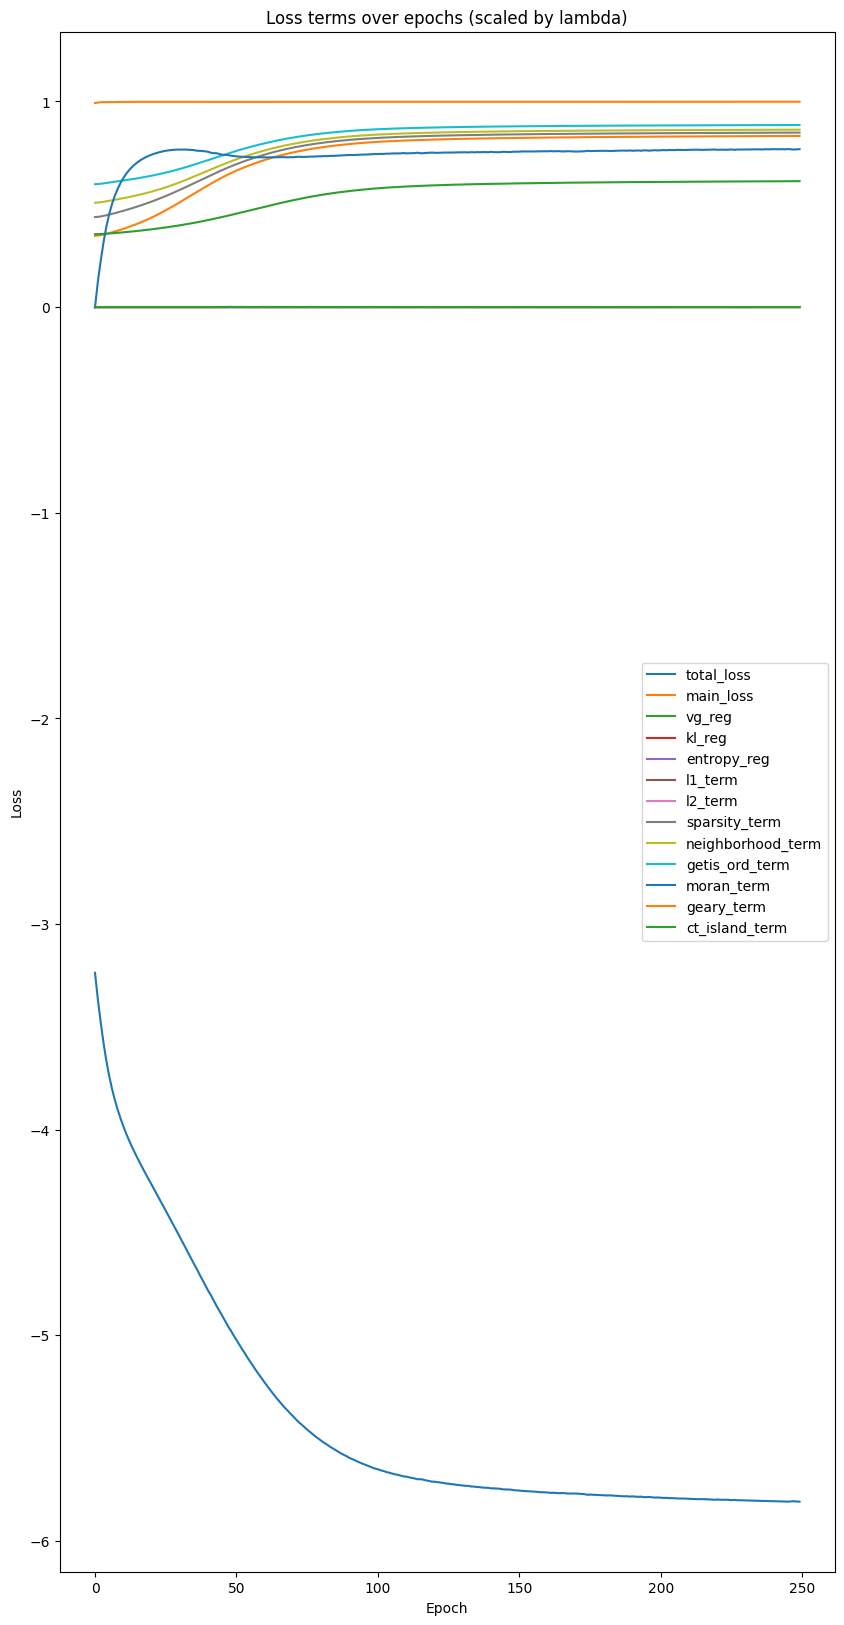

In [11]:
tgl.plot_training_history(adata_map=ad_map, hyperpams=mapper.hparams,
                   log_scale=False, lambda_scale=True)

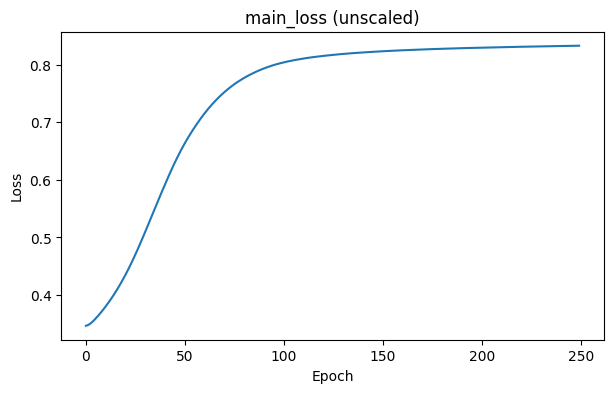

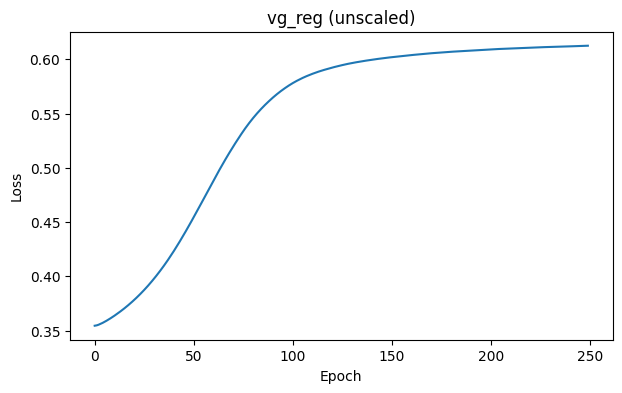

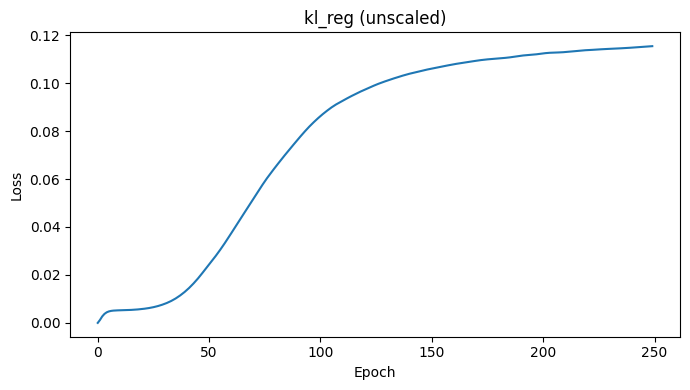

In [13]:
# Plot main loss
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "vg_reg", "kl_reg"], 
                   lambda_coeff = [1, 1, mapper.hparams.lambda_d], lambda_scale=False)

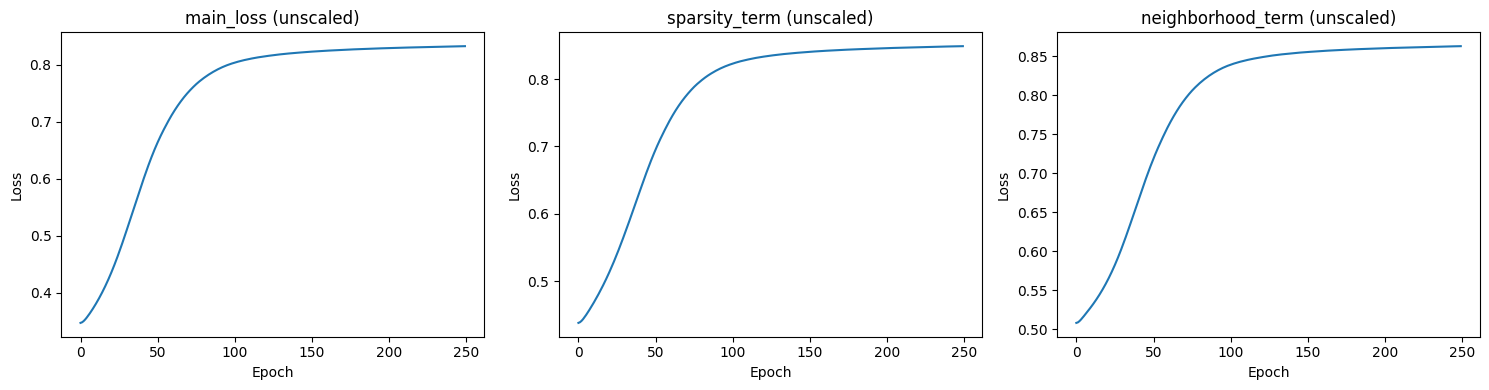

In [14]:
# Score terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "sparsity_term", "neighborhood_term"], lambda_scale=False,
                   make_subplot=True, subplot_shape=(1,3))

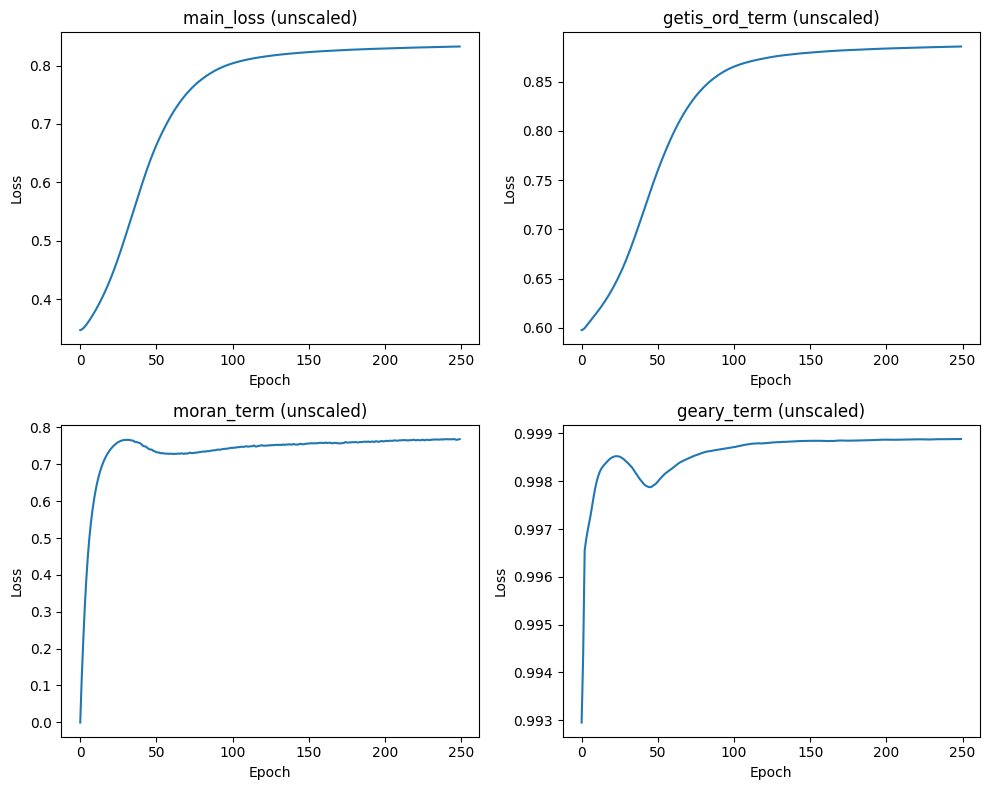

In [15]:
# LISA terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "getis_ord_term", "moran_term", "geary_term"], 
                    lambda_scale=False, make_subplot=True)

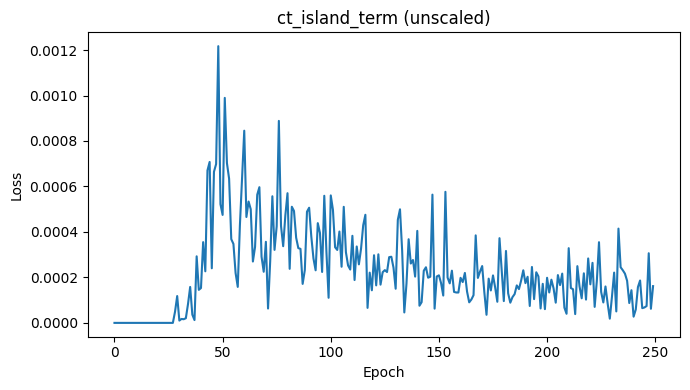

In [16]:
# CT islands term
tgl.plot_loss_terms(adata_map=ad_map, loss_key="ct_island_term", lambda_scale=False)

### Validate Model

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


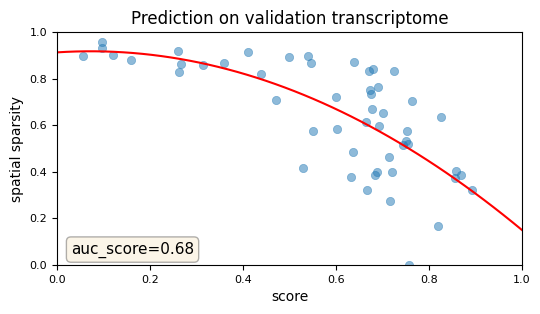

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric       ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           val_AUC           │     0.6801009774208069      │
│           val_JS            │     0.2957155406475067      │
│           val_PCC           │     0.49188926815986633     │
│          val_RMSE           │     0.9816303253173828      │
│          val_SSIM           │     0.31281769275665283     │
│         val_entropy         │     0.08462736755609512     │
│          val_score          │     0.5835639238357544      │
│ val_sparsity-weighted_score │    0.013357068412005901     │
└─────────────────────────────┴─────────────────────────────┘

In [17]:
# call trainer.validate()
full_val = tgl.validate_mapping_experiment(mapper, mapper_data)

### Sparsity Analysis

In [18]:
# Project all sc data onto spots
ad_ge = tgl.project_sc_genes_onto_space(ad_map, mapper_data)
ad_ge

AnnData object with n_obs × n_vars = 2133 × 31053
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'instance_id', 'centroid_x', 'centroid_y', 'region'
    var: 'gene_ids', 'feature_types', 'sparsity', 'is_training'
    uns: 'overlap_genes', 'training_genes'

In [19]:
# Create training genes scores dataframe
df = tgl.compare_spatial_gene_expr(ad_ge, mapper_data)

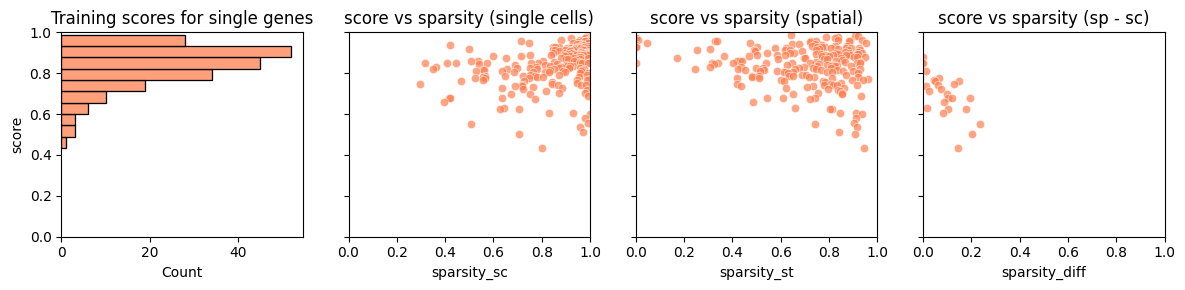

In [20]:
# Plot training scores panels
tgl.plot_training_scores(df)

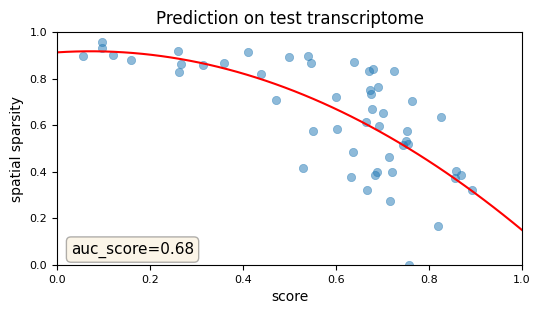

In [21]:
# Plot polyfit on test genes
tgl.plot_auc_curve(df)  # same as validation genes

### Save results

In [22]:
# Write tgl.map_cells_to_space() output to .h5ad
sc.write(filename='/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/adata_map_0', adata=ad_map, ext='h5ad')

### Reload from ckpt

In [24]:
# Check state dict
mapper.state_dict().keys()

odict_keys(['M'])

In [ ]:
# Load checkpoint
ckpt = torch.load("checkpoints/last.ckpt", map_location="cpu")  # last
print(ckpt['state_dict'].keys())
ckpt['hyper_parameters']

odict_keys(['M'])

In [ ]:
### does not work yet
from tangramlit import MapperLightning as ML

# Load into mapper
mapper_reload = ML.load_from_checkpoint("checkpoints/last.ckpt")
mapper_reload.state_dict()


RuntimeError: Error(s) in loading state_dict for MapperLightning:
	size mismatch for M: copying a param with shape torch.Size([80799, 2133]) from checkpoint, the shape in current model is torch.Size([0]).

## Full Mapper with Filter

In [9]:
# Update config
config_filt = config
config_filt['filter'] = True
config_filt['target_count'] = None
config_filt

{'cluster_label': 'Allen.class_label',
 'lambda_count': 1e-05,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 1,
 'learning_rate': 0.1,
 'filter': True,
 'num_epochs': 1000,
 'random_state': 42,
 'target_count': None}

### Model training

In [10]:
ad_map_filt, mapper_filt, mapper_data_filt = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config_filt,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 172 M  | n/a  
---------------------------------------------------------
172 M     Trainable params
0         Non-trainable params
172 M     Total params
689.700   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([80799, 51])
G matrix shape: torch.Size([2133, 51])

Validation 0: {'val_score': 0.35324105620384216, 'val_sparsity-weighted_score': 0.008449673652648926, 'val_AUC': 0.43770620226860046, 'val_entropy': 0.9348850846290588}


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 201 genes
S matrix shape: torch.Size([80799, 201])
G matrix shape: torch.Size([2133, 201])


Trainig:   0%|          | 1/1000 [00:26<7:18:09, 26.32s/it]

Epoch 0: {'loss': -2.7289299964904785, 'main_loss': 0.35358119010925293, 'vg_reg': 0.36662253737449646, 'kl_reg': 1.3166806311915025e-08, 'entropy_reg': -0.0005790185532532632, 'l1_term': 1.375221785337999e-07, 'l2_term': 1.7236176375057255e-10, 'sparsity_term': 0.4491614103317261, 'neighborhood_term': 0.513298511505127, 'getis_ord_term': 0.6016843914985657, 'moran_term': 0.0009468163480050862, 'geary_term': 0.9928035736083984, 'ct_island_term': 0.0, 'count_reg': 0.38157913088798523, 'filt_reg': 0.16701018810272217}


Trainig:   5%|▍         | 49/1000 [20:52<6:45:48, 25.60s/it]Metric val_score improved. New best score: 0.472
Epoch 49, global step 50: 'val_score' reached 0.47163 (best 0.47163), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=49-val_score=0.472.ckpt' as top 3



Validation 49: {'val_score': 0.47163015604019165, 'val_sparsity-weighted_score': 0.010883355513215065, 'val_AUC': 0.543464720249176, 'val_entropy': 0.8157791495323181}


Trainig:  10%|▉         | 99/1000 [42:18<6:26:06, 25.71s/it]Monitored metric val_score did not improve in the last 1 records. Best score: 0.472. Signaling Trainer to stop.
Epoch 99, global step 100: 'val_score' reached 0.45963 (best 0.47163), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=99-val_score=0.460.ckpt' as top 3



Validation 99: {'val_score': 0.4596320390701294, 'val_sparsity-weighted_score': 0.010698136873543262, 'val_AUC': 0.5379365086555481, 'val_entropy': 0.5451240539550781}


Trainig:  10%|█         | 100/1000 [42:50<6:25:36, 25.71s/it]


### Loss Landscape

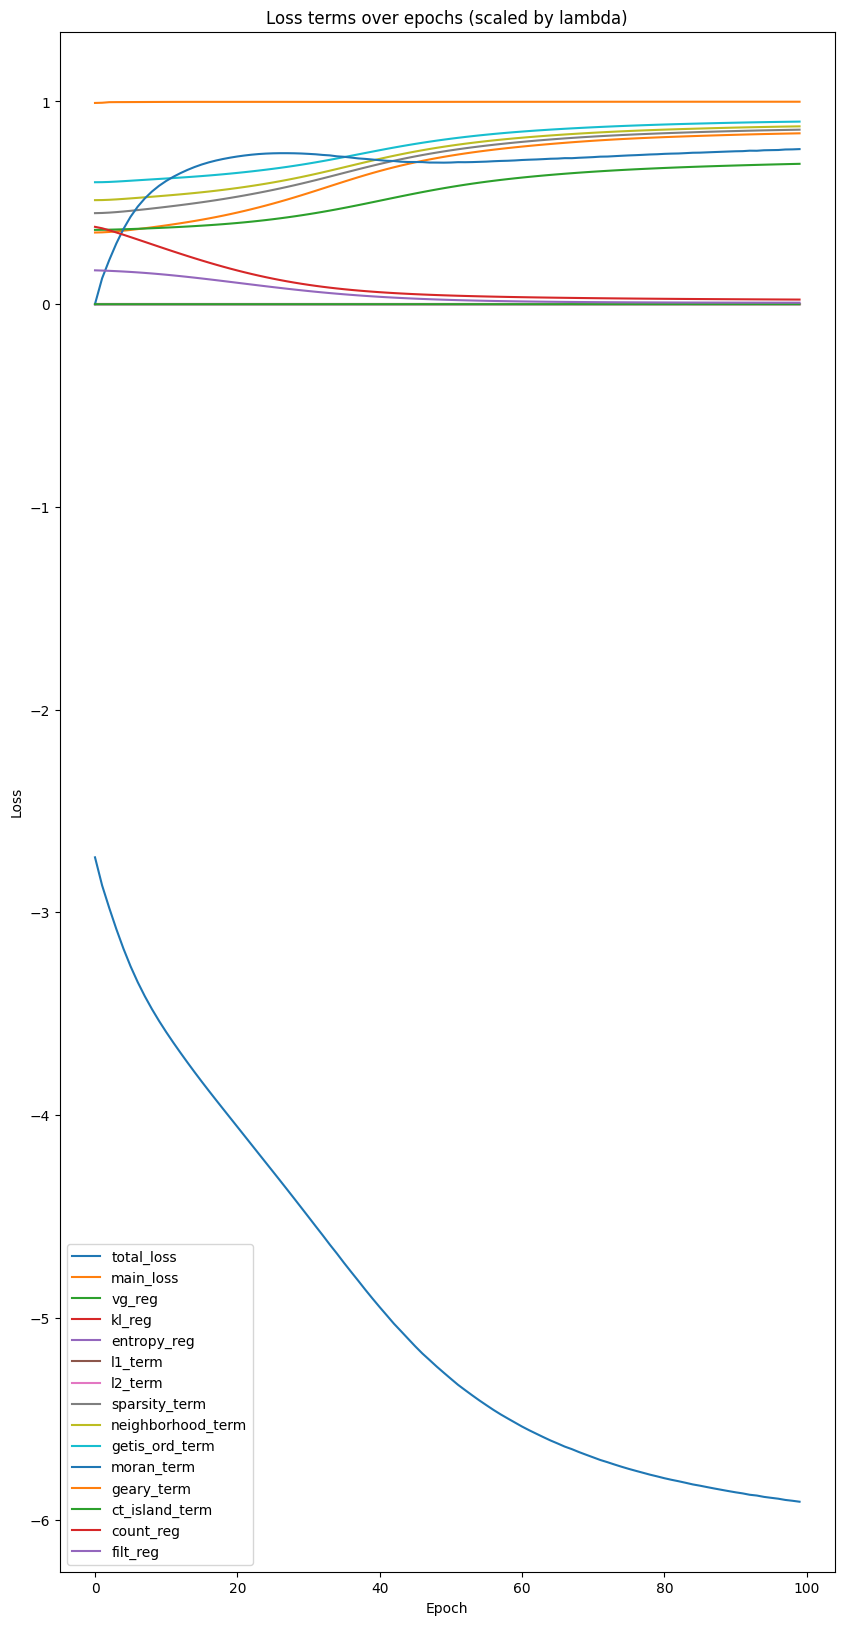

In [11]:
tgl.plot_training_history(adata_map=ad_map_filt, hyperpams=mapper_filt.hparams,
                   log_scale=False, lambda_scale=True)

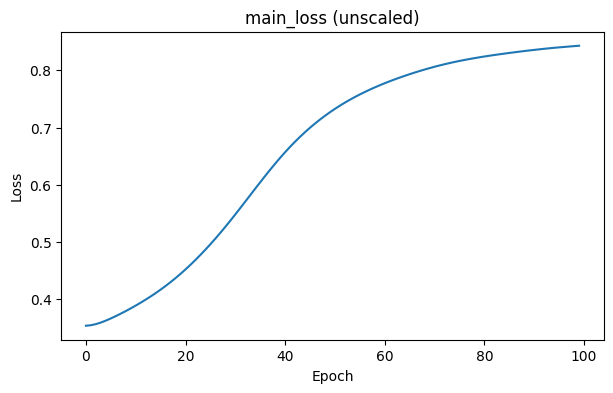

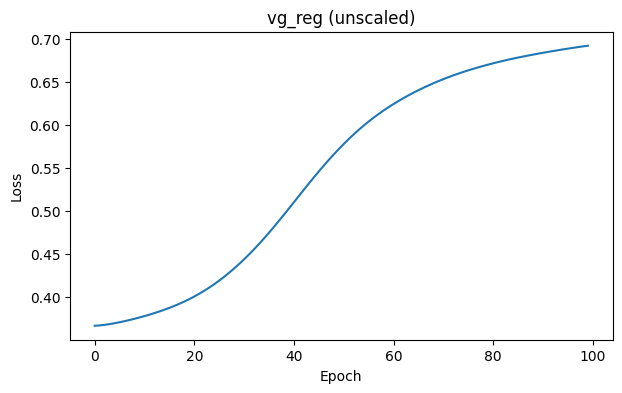

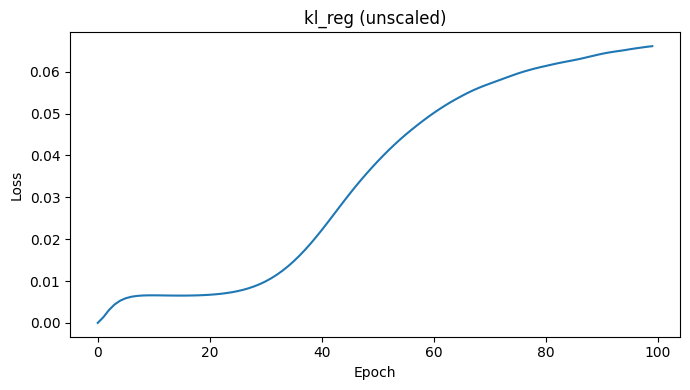

In [13]:
# Plot main loss and v/g term
tgl.plot_loss_terms(adata_map=ad_map_filt, loss_key=["main_loss", "vg_reg", "kl_reg"], 
                    lambda_coeff = [1, 1, mapper_filt.hparams.lambda_d], lambda_scale=False)

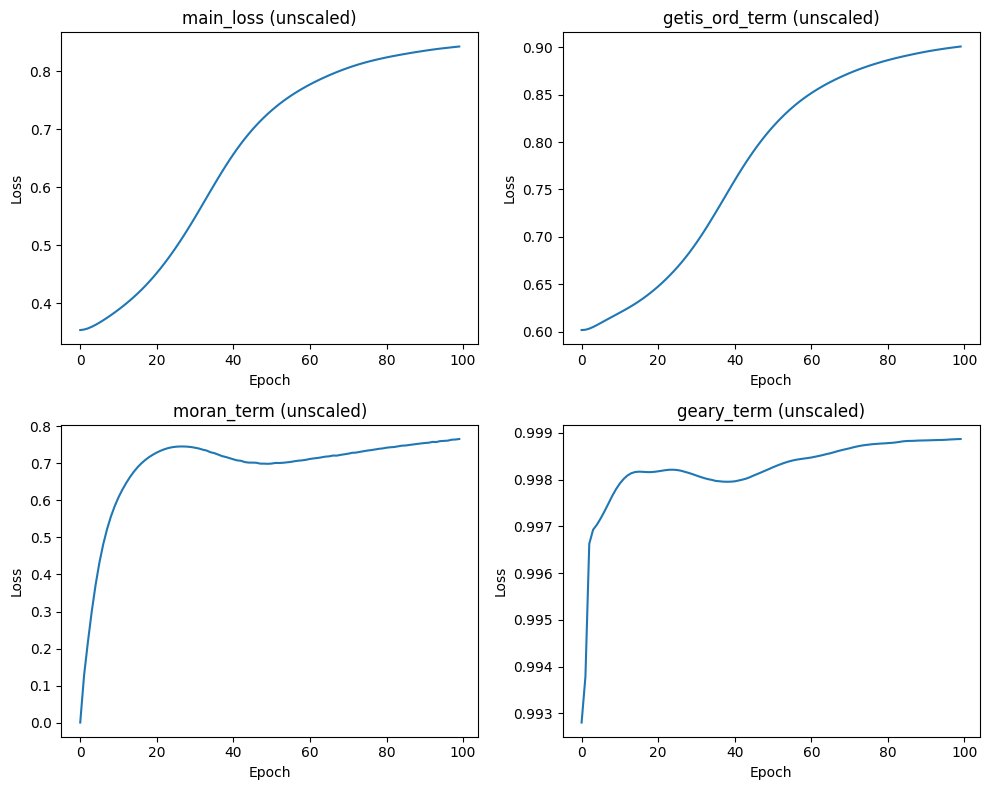

In [16]:
tgl.plot_loss_terms(adata_map=ad_map_filt, loss_key=["main_loss", "getis_ord_term", "moran_term", "geary_term"], 
                   lambda_scale=False, make_subplot=True)


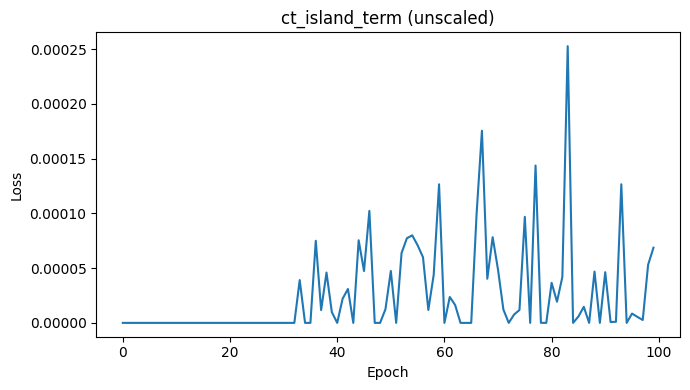

In [17]:
tgl.plot_loss_terms(adata_map=ad_map_filt, loss_key="ct_island_term", lambda_scale=False)

#### Filter analysis

In [19]:
# Check target count auto setting
print(f"Spatial spots: {adata_st.n_obs}, target count: {mapper_filt.hparams.target_count}")

Spatial spots: 2133, target count: 2155


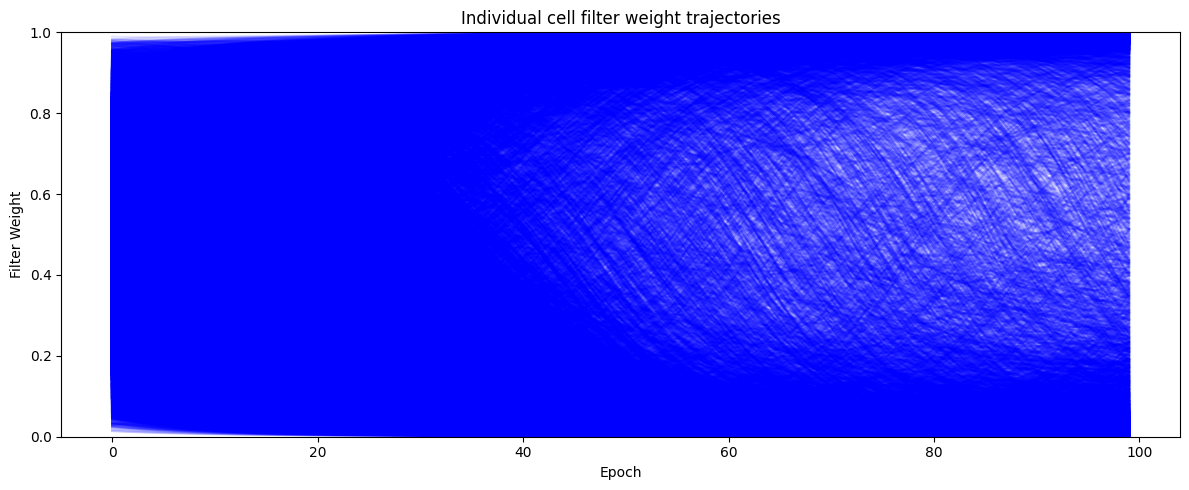

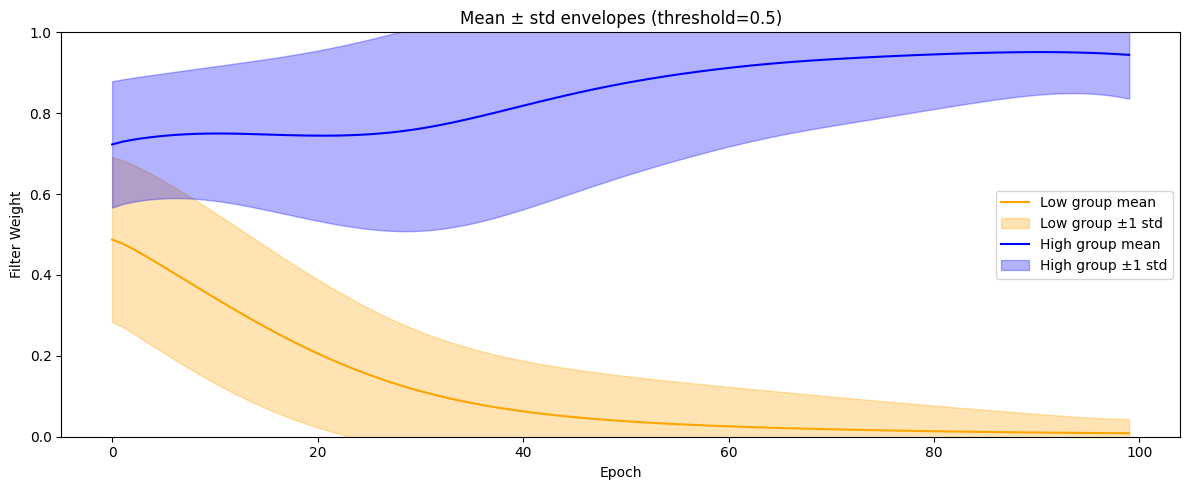

In [20]:
# Plot filter trajecotries
tgl.plot_filter_weights(ad_map_filt, plot_heatmap=False, plot_spaghetti=True, plot_envelope=True)

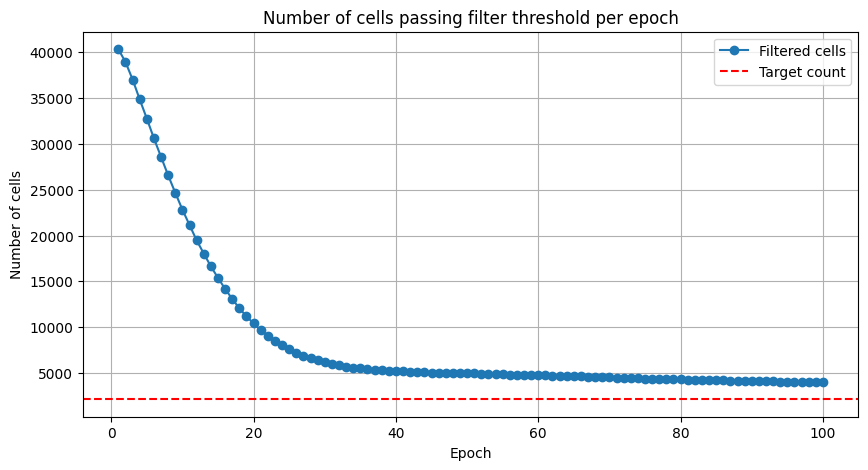

In [21]:
# Plot selected count trajectory
tgl.plot_filter_count(ad_map_filt, target_count=mapper_filt.hparams.target_count)

Pearson correlation coefficient of filter values: 0.26658811627630435


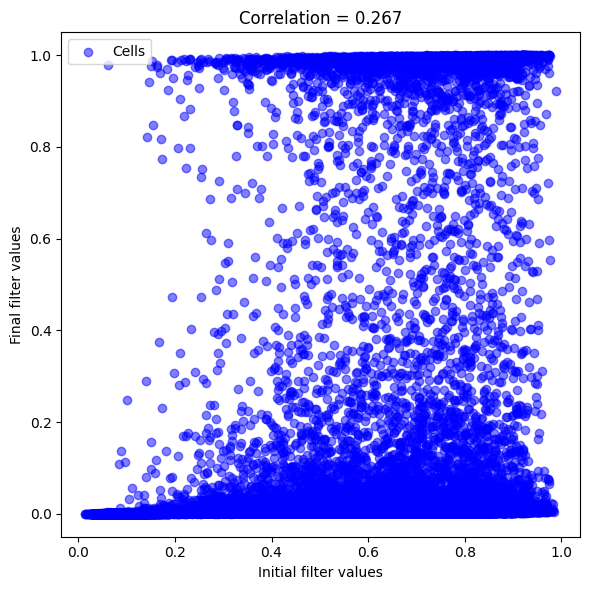

In [23]:
# Inspect filter IC correlation
filt_corr = tgl.compute_filter_corr(ad_map_filt, plot_regression=False)

### Validate Model

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


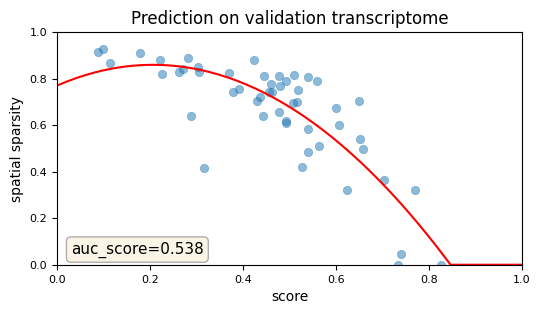

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric       ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           val_AUC           │     0.5379365086555481      │
│           val_JS            │     0.3441994786262512      │
│           val_PCC           │     0.32612156867980957     │
│          val_RMSE           │      1.151119351387024      │
│          val_SSIM           │     0.22644968330860138     │
│         val_entropy         │     0.5451240539550781      │
│          val_score          │     0.4596320390701294      │
│ val_sparsity-weighted_score │    0.010698136873543262     │
└─────────────────────────────┴─────────────────────────────┘

In [24]:
# call trainer.validate()
full_val_filt = tgl.validate_mapping_experiment(mapper_filt, mapper_data_filt)

### Save results

In [25]:
# Write tgl.map_cells_to_space() output to .h5ad
sc.write(filename='/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/adata_map_filt_0', adata=ad_map_filt, ext='h5ad')

# New test

In [9]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Preprocessing data...
Using 252 shared marker genes.


Allocating nearest neighbor graphs to dense tensors...
spatial_graph_conn allocated: shape=(2133, 2133), size=17.36 MiB
spatial_graph_dist allocated: shape=(2133, 2133), size=17.36 MiB
Done.
Computing CT OHE...
Done.



  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 172 M  | n/a  
---------------------------------------------------------
172 M     Trainable params
0         Non-trainable params
172 M     Total params
689.377   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([80799, 51])
G matrix shape: torch.Size([2133, 51])


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 201 genes
S matrix shape: torch.Size([80799, 201])
G matrix shape: torch.Size([2133, 201])


Trainig: 100%|██████████| 1000/1000 [3:02:34<00:00, 10.95s/it]


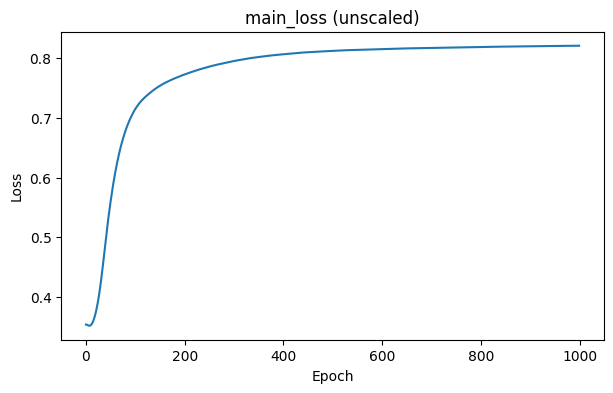

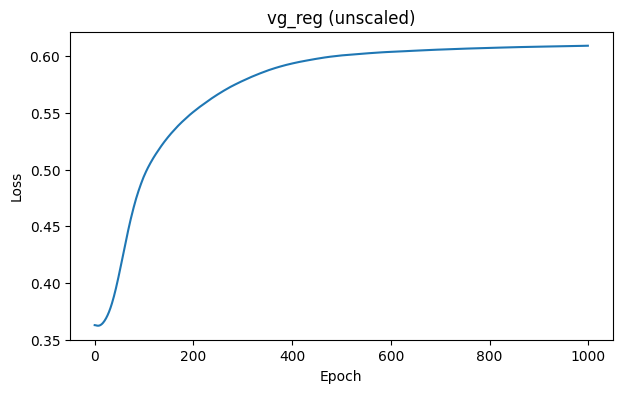

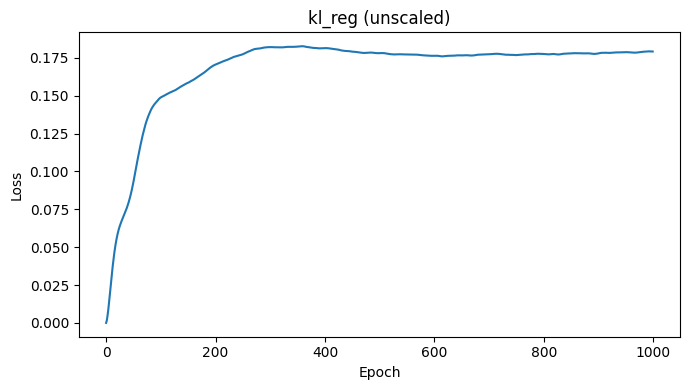

In [10]:
# Plot main loss
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "vg_reg", "kl_reg"], 
                   lambda_coeff = [1, 1, mapper.hparams.lambda_d], lambda_scale=False)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Preprocessing data...
Using 252 shared marker genes.


Allocating nearest neighbor graphs to dense tensors...
spatial_graph_conn allocated: shape=(2133, 2133), size=17.36 MiB
spatial_graph_dist allocated: shape=(2133, 2133), size=17.36 MiB
Done.
Computing CT OHE...
Done.


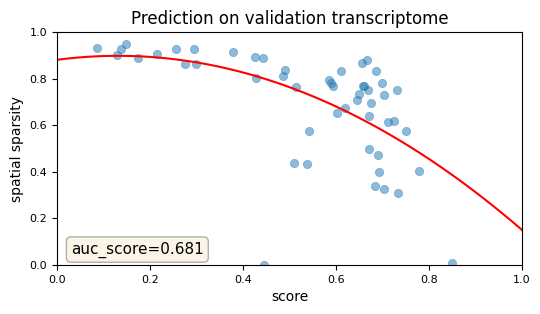

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_AUC          │    0.6808131337165833     │
│          val_JS           │    0.32161280512809753    │
│          val_PCC          │    0.45118269324302673    │
│         val_RMSE          │    1.0288493633270264     │
│         val_SSIM          │    0.32222864031791687    │
│         val_score         │    0.5406198501586914     │
└───────────────────────────┴───────────────────────────┘

In [11]:
# call trainer.validate()
full_val = tgl.validate_mapping_experiment(mapper, mapper_data)

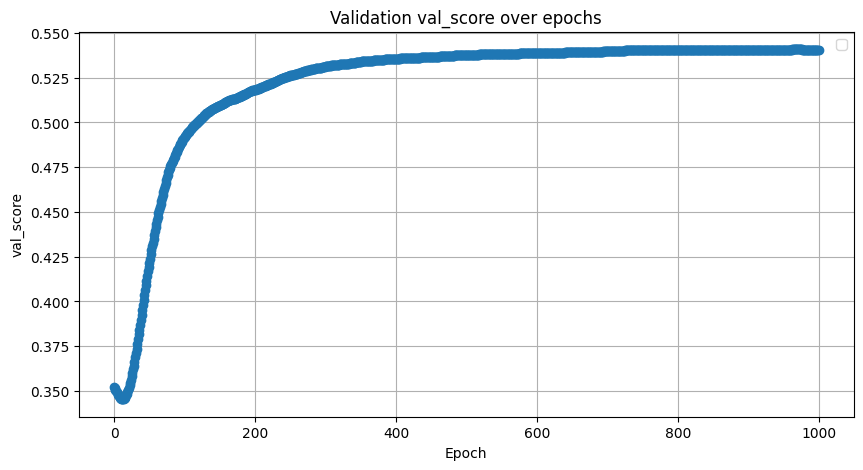

ValueError: x and y must have same first dimension, but have shapes (1000,) and (0,)

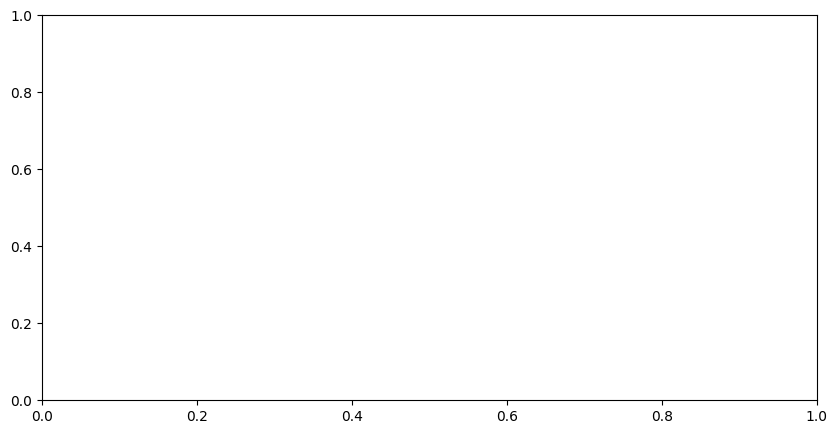

In [12]:
tgl.plot_validation_metrics_history(adata_map=ad_map)

# Benchmarking data stuff


In [2]:
import pandas as pd

In [ ]:
df_full = pd.read_excel('/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/benchmarking/bench_data_full.xlsx', index_col=0)
df_full

,PCC,SSIM,RMSE,JS,tool,Image-based
ABCC4,0.201148,0.140296,1.264003,0.394450,Tangram,Data1
ACP5,0.202152,0.103651,1.263208,0.400025,Tangram,Data1
ACVR1,0.335924,0.222466,1.152455,0.337147,Tangram,Data1
ACVR2A,0.287731,0.237108,1.193540,0.355771,Tangram,Data1
ADORA2B,0.186953,0.135498,1.275184,0.455996,Tangram,Data1
...,...,...,...,...,...,...
CSPG4,0.075618,0.065201,1.359693,0.404754,stPlus,Data9
NOS1,0.379851,0.150665,1.113687,0.478505,stPlus,Data9
PRSS12,0.041028,0.017642,1.384898,0.365934,stPlus,Data9
EGFEM1,0.064629,0.092718,1.367750,0.342917,stPlus,Data9


In [8]:
df_mine = pd.read_excel('/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/ablation_study/Dataset1/ablated_baseline/benchmark.xlsx', index_col=0)
df_mine


,score,PCC,RMSE,JS,SSIM,is_training,is_validation,sparsity_st,sparsity_sc,sparsity_diff,moranI,gearyC
nr2f1,0.984734,0.975026,0.223492,0.035083,0.963282,True,False,0.428535,0.997269,-0.568734,0.284838,0.715942
nkx2-3,0.979388,0.980356,0.198213,0.085332,0.964831,True,False,0.774510,0.997542,-0.223032,0.112192,0.893896
pax8,0.976982,0.978847,0.205685,0.104599,0.958897,True,False,0.829205,0.997269,-0.168063,0.136656,0.875733
vcam1,0.975775,0.977000,0.214475,0.091169,0.958939,True,False,0.817853,0.998361,-0.180508,0.047915,0.943876
tbx5,0.975290,0.978032,0.209609,0.102037,0.956799,True,False,0.816047,0.997542,-0.181494,0.246061,0.767892
...,...,...,...,...,...,...,...,...,...,...,...,...
mixl1,0.277563,0.036481,1.388178,0.522861,0.009955,False,True,0.897575,0.834471,0.063103,0.018644,0.990343
tdo2,0.273192,-0.010662,1.421733,0.490725,0.007131,False,True,0.855779,0.971866,-0.116086,0.001431,1.013058
mrap,0.269686,0.083731,1.353713,0.467942,0.106785,False,True,0.829979,0.998634,-0.168655,0.054242,0.937223
sox10,0.211820,0.016340,1.402612,0.494500,0.042567,False,True,0.838751,0.998361,-0.159610,0.216072,0.785029


In [44]:
adata_map = sc.read('/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/ablation_study/Dataset5/Dataset5_full.h5ad')


In [22]:
adata_map.uns['training_history'].keys()

dict_keys(['count_reg', 'ct_island_term', 'entropy_reg', 'filt_reg', 'geary_term', 'getis_ord_term', 'kl_reg', 'l1_term', 'l2_term', 'main_loss', 'moran_term', 'neighborhood_term', 'sparsity_term', 'total_loss', 'vg_reg'])

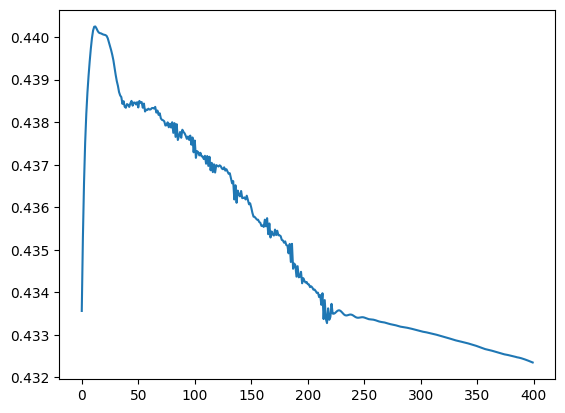

In [45]:
import matplotlib.pyplot as plt

plt.plot(adata_map.uns['validation_history']['val_score'])
plt.show()

In [46]:
import pandas as pd


In [48]:
df = pd.read_excel('/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/ablation_study/Dataset5/ablated_full/benchmark.xlsx', index_col=0)



In [49]:
df

,score,PCC,RMSE,JS,SSIM,is_training,is_validation,sparsity_st,sparsity_sc,sparsity_diff,moranI,gearyC
gene,,,,,,,,,,,,
5031425f14rik,0.995111,0.999878,0.015612,0.132437,0.930768,True,False,0.962715,0.993901,-0.031187,-0.005997,0.998982
ankfn1,0.993520,0.998647,0.052023,0.177387,0.887117,True,False,0.981148,0.979044,0.002104,-0.001050,0.991967
1810046k07rik,0.991202,0.999750,0.022366,0.108693,0.952257,True,False,0.891915,0.997405,-0.105490,0.039236,0.966529
ccnb1,0.990483,0.999522,0.030935,0.106342,0.954912,True,False,0.872643,0.997340,-0.124696,0.048079,0.952425
corin,0.990332,0.999103,0.042354,0.142544,0.920823,True,False,0.931713,0.984364,-0.052650,0.048234,0.941209
...,...,...,...,...,...,...,...,...,...,...,...,...
rnf152,0.182673,0.031898,1.391475,0.619404,0.007699,False,True,0.967323,0.780705,0.186618,0.023247,0.989549
cacng5,0.176603,0.064749,1.367663,0.624638,0.007439,False,True,0.970674,0.851943,0.118731,0.022082,0.987024
pou3f3,0.169262,0.036869,1.387898,0.628097,0.013631,False,True,0.972350,0.377019,0.595331,0.004811,0.994253
